# Product Recommendation

In [1]:
import numpy as np
import pandas as pd
from customized import preprocess
from customized import metrics
from customized import product_recommendation
from striatum import MAB
from striatum.storage.action import Action
from neural_exploration import neuralucb_main
# import importlib
# importlib.reload(product_recommendation)

## Context Comparison

### without class weights

[Test] change Double to Float
Step [2/2], Reconstructed Loss: 0.0213
product feature: (200, 32)


  2% (26 of 1000) |                      | Elapsed Time: 0:00:00 ETA:  00:00:00

streamer feature: (200, 23)
small streamer-product: (200, 55)


100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02


Recommend Ratio: 0.20 %
Accuracy: 95.90 %
Correct: 959
Regret: 0.041
Early Stop times: 33
Current seed: 2617103331022522357


100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02


Recommend Ratio: 0.30 %
Accuracy: 94.80 %
Correct: 948
Regret: 0.052
Early Stop times: 37
Current seed: 13959052549812513893
basket's regret: 0.041
streamer's regret: 0.052


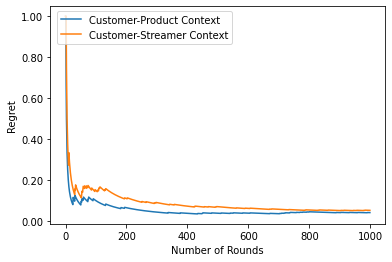

basket's hit ratio: 33.87 %
streamer's hit ratio: 32.22 %


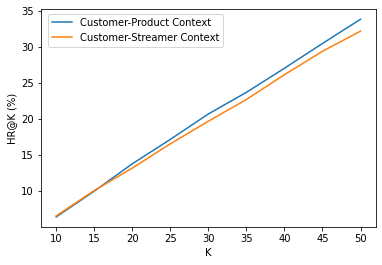

In [6]:
# experiments = ['static', 'temporal']
# mylabels = ['Static Context', 'Temporal Context']
experiments = ['basket', 'streamer']
mylabels = ['Customer-Product Context', 'Customer-Streamer Context']
fig_name = 'lers_temporal_sm'
regrets_context, hr_context, small_reward_pivot, cust_id, reward_cust_id, reward_prod_id, topk_context= product_recommendation.main(experiments, mylabels, fig_name, 1000, 200)

### with class weights

[Test] change Double to Float
Step [2/2], Reconstructed Loss: 0.0213
product feature: (200, 32)


  2% (26 of 1000) |                      | Elapsed Time: 0:00:00 ETA:  00:00:00

streamer feature: (200, 23)
small streamer-product: (200, 55)
total: 200000, pos: 6652, neg: 193348
Weight for class 0: 0.52
Weight for class 1: 15.03


100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02


Recommend Ratio: 28.20 %
Accuracy: 70.80 %
Correct: 708
Regret: 0.292
Early Stop times: 22
Current seed: 12610666189808755946


100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02


Recommend Ratio: 44.50 %
Accuracy: 56.30 %
Correct: 563
Regret: 0.437
Early Stop times: 25
Current seed: 3334858110421161694
basket's regret: 0.292
streamer's regret: 0.437


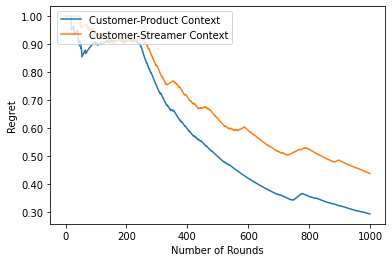

basket's hit ratio: 37.69 %
streamer's hit ratio: 35.87 %


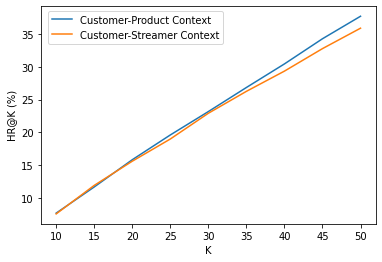

In [5]:
experiments = ['basket', 'streamer']
mylabels = ['Customer-Product Context', 'Customer-Streamer Context']
fig_name = 'lers_temporal_sm_weights'
_, _, _, _, _, _, _ = product_recommendation.main(experiments, mylabels, fig_name, 1000, 200, class_weight = True)

## Uncertainty Structure

### without class weights

In [ ]:
experiments = ['aenn', 'vaenn', 'aebnn', 'vaebnn']
mylabels = ['Without Uncetainty', 'Context Uncertainty', 'Recommendation Uncertainty', 'Both Uncertainties']
fig_name = 'lers_structure_sm'

regrets_structure, hr_structure, _, _, _, _, topk_structure = product_recommendation.main(experiments, mylabels, fig_name, 1000, 200)

### with class weights

In [ ]:
experiments = ['aenn', 'vaenn', 'aebnn', 'vaebnn']
mylabels = ['Without Uncetainty', 'Context Uncertainty', 'Recommendation Uncertainty', 'Both Uncertainties']
fig_name = 'lers_structure_sm_weights'

regrets_structure_w, hr_structure_w, _, _, _, _, topk_structure_w  = product_recommendation.main(experiments, mylabels, fig_name, 1000, 200, class_weight = True)

# MAB

In [ ]:
import importlib
importlib.reload(MAB)
def main(num, full_context, context_id, rewards, reward_prod_id, lers_regret, lers_hr): # 2602人, 815dim
    
    actions = []
    for prod_id in reward_prod_id:
        action = Action(int(prod_id))
        actions.append(action)
    user_features = pd.DataFrame(np.array(full_context), index=context_id)
    small_rewards_df = pd.melt(rewards, ignore_index=False, var_name='商品id', value_name='reward')\
                    .loc[context_id].reset_index()
    print(f"user features: {user_features.shape}, reward targets: {rewards.shape}")
    
    experiment_bandit = ['aenn','vaenn','aebnn','vaebnn','UCB1', 'LinUCB', 'Exp3', 'NeuralUCB','random']
    mab_bandit = ['random', 'UCB1', 'LinUCB', 'Exp3']
    predict_id = {}
    rec_id = {}
    regret = {}
    coverage = {} 
    hr = {}
    topk = {}
    mylabels = ['LERS (Without Uncertainty)','LERS (Context Uncertainty)','LERS (Recommendation Uncertainty)', 'LERS (Both Uncertainties)',\
               'UCB1', 'LinUCB', 'Exp3', 'NeuralUCB', 'Random']

    for bandit in experiment_bandit:   
        print("-----")
        print(bandit)
        if bandit in mab_bandit:      
            policy = MAB.policy_generation(bandit, actions)
            seq_error, rec_id[bandit], predict_id[bandit] = MAB.policy_evaluation(policy, bandit, num, user_features, rewards, actions, len(actions))
            regret[bandit] = MAB.regret_calculation(seq_error)
            if bandit != 'random':
                hr[bandit], k_list, topk[bandit] = metrics.cal_hit_ratio_mab(small_rewards_df, predict_id[bandit], min_val=10, max_val=55, step=5)

        elif bandit == 'NeuralUCB':
            neuralUCB_regret, neuralUCB_reward_df, predict_id[bandit] = neuralucb_main.myNeuralUCB(user_features, rewards, p=0.2, hidden_size=32, epochs=10, use_cuda=False, seed=np.random.seed(2022))
            regret['NeuralUCB'] = neuralUCB_regret
            hr[bandit], _, topk[bandit]  = metrics.cal_hit_ratio_neuralucb(small_rewards_df, predict_id[bandit], min_val=10, max_val=55, step=5)
        else:
            regret[bandit] = lers_regret[bandit]  
            hr[bandit] = lers_hr[bandit]
    
        
    # plot regret
    metrics.plot_regret(regret, mylabels, 'all_sm', rounds=num)
    # plot hit ratio
    metrics.plot_hit_ratio(hr, k_list, mylabels, 'all_sm')
    
    return regret, hr, predict_id, topk

## blurry_context

In [ ]:
# mab_context = np.load('data/mab_context_new.npy')
# mab_context, mab_context_id, _ = preprocess.trim_cust_for_context_sort(mab_context, cust_id, reward_cust_id)
# regret, hr, predict_id, topk_mab = main(len(mab_context_id), mab_context, mab_context_id, small_reward_pivot, reward_prod_id, regrets_structure_w, hr_structure_w) 

In [ ]:
mab_context = np.load('data/mab_latent30.npy')
mab_context, mab_context_id, _ = preprocess.trim_cust_for_context_sort(mab_context, cust_id, reward_cust_id)
regret, hr, predict_id, topk_mab = main(len(mab_context_id), mab_context, mab_context_id, small_reward_pivot, reward_prod_id, regrets_structure_w, hr_structure_w) 